####         INF2178 Final Code - Effect of Multiple Factors on the Level of Cooperation and Mental Instability at the Time of Arrest
####    This code is contributed by Laien Zhou (1005490434) and Yuelin Liu (1003175164)

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels
from scipy import stats
import statsmodels.stats.api as sms
from statsmodels.stats.power import TTestIndPower
import matplotlib.gridspec as gridspec

!pip install pingouin
!pip install seaborn matplotlib

  Using cached pingouin-0.5.3-py3-none-any.whl (198 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
  Using cached pandas_flavor-0.5.0-py3-none-any.whl (7.1 kB)
  Using cached outdated-0.2.2-py2.py3-none-any.whl (7.5 kB)
  Using cached xarray-2023.3.0-py3-none-any.whl (981 kB)
  Using cached lazy_loader-0.2-py3-none-any.whl (8.6 kB)
  Using cached littleutils-0.2.2-py3-none-any.whl


In [2]:
# read the data
df = pd.read_csv("https://raw.githubusercontent.com/LaienZhou/inf2178-expdesignfordatascience-w23/main/project%20dataset/Arrests_and_Strip_Searches_(RBDC-ARR-TBL-001).csv")

# valid data
# sex:
valid_sex = (df["Sex"] == "M") | (df["Sex"] == "F")
# perceived_race:
valid_race = (df["Perceived_Race"] == "White") | (df["Perceived_Race"] == "Black") | (df["Perceived_Race"] == "East/Southeast Asian") | (df["Perceived_Race"] == "South Asian") | (df["Perceived_Race"] == "Middle-Eastern") | (df["Perceived_Race"] == "Latino") | (df["Perceived_Race"] == "Indigenous")
valid_data = valid_sex & valid_race
df = df[valid_data]

# data rename & changes on representation
# ArrestLocDiv -> intoronto :
df.rename(columns={'ArrestLocDiv':'intoronto'}, inplace=True)
df.loc[df["intoronto"] != "XX","intoronto"] = "yes"
df.loc[df["intoronto"] == "XX","intoronto"] = "no"
# Continuous dependent variables: Cooperation score
df["Cooperation_score"] = 7.5 + 2.5*df["Actions_at_arrest___Cooperative"] - 0.5*df["Actions_at_arrest___Concealed_i"] - 2*df["Actions_at_arrest___Combative__"] - 1.5*df["Actions_at_arrest___Resisted__d"] - 1*df["Actions_at_arrest___Mental_inst"] - 2.5*df["Actions_at_arrest___Assaulted_o"]
# Continuous control variables: Threat Index
df['threat_index'] = 2*df['Actions_at_arrest___Combative__'] + 1*df['Actions_at_arrest___Resisted__d'] + 1.5*df['Actions_at_arrest___Assaulted_o']
# Mental instability at arrest
df.rename(columns={'Actions_at_arrest___Mental_inst':'Mental_instab'}, inplace=True)
df.loc[df["Mental_instab"] == 1,"Mental_instab"] = "yes"
df.loc[df["Mental_instab"] == 0,"Mental_instab"] = "no"

# data reallocation

# Age_group__at_arrest_:
df.loc[(df["Age_group__at_arrest_"] == "Aged 17 years and under") | (df["Age_group__at_arrest_"] == "Aged 17 years and younger") ,["Age_group__at_arrest_"]] = "-18"
df.loc[(df["Age_group__at_arrest_"] == "Aged 65 years and older") | (df["Age_group__at_arrest_"] == "Aged 65 and older") ,["Age_group__at_arrest_"]] = "65+"
df.loc[(df["Age_group__at_arrest_"] == "Aged 18 to 24 years") ,["Age_group__at_arrest_"]] = "18-24"
df.loc[(df["Age_group__at_arrest_"] == "Aged 25 to 34 years") ,["Age_group__at_arrest_"]] = "25-34"
df.loc[(df["Age_group__at_arrest_"] == "Aged 35 to 44 years") ,["Age_group__at_arrest_"]] = "35-44"
df.loc[(df["Age_group__at_arrest_"] == "Aged 45 to 54 years") ,["Age_group__at_arrest_"]] = "45-54"
df.loc[(df["Age_group__at_arrest_"] == "Aged 55 to 64 years") ,["Age_group__at_arrest_"]] = "55-64"

# select columns in interest and drop NA 
df = df[['Sex', 'Perceived_Race', 'Age_group__at_arrest_', 'intoronto', 'Cooperation_score', 'threat_index', 'Mental_instab']].copy().dropna()

df

,Sex,Perceived_Race,Age_group__at_arrest_,intoronto,Cooperation_score,threat_index,Mental_instab
0,M,White,35-44,yes,10.0,0.0,no
1,M,White,35-44,yes,7.5,0.0,no
3,M,Black,25-34,no,7.5,0.0,no
4,M,South Asian,25-34,no,7.5,0.0,no
5,M,South Asian,25-34,yes,10.0,0.0,no
...,...,...,...,...,...,...,...
65270,F,White,25-34,no,7.5,0.0,no
65271,F,Indigenous,25-34,no,6.0,1.0,no
65272,M,South Asian,35-44,yes,7.5,0.0,no
65273,F,White,45-54,no,7.5,0.0,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60187 entries, 0 to 65275
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Sex                    60187 non-null  object 
 1   Perceived_Race         60187 non-null  object 
 2   Age_group__at_arrest_  60187 non-null  object 
 3   intoronto              60187 non-null  object 
 4   Cooperation_score      60187 non-null  float64
 5   threat_index           60187 non-null  float64
 6   Mental_instab          60187 non-null  object 
dtypes: float64(2), object(5)
memory usage: 3.7+ MB


In [5]:
# value count
for column in df.columns.values.tolist():
    print(df[column].value_counts())
    print("-----------------------------------------")

M    48505
F    11682
Name: Sex, dtype: int64
-----------------------------------------
White                   27708
Black                   17518
East/Southeast Asian     4412
South Asian              3613
Middle-Eastern           3237
Indigenous               1932
Latino                   1767
Name: Perceived_Race, dtype: int64
-----------------------------------------
25-34    19299
35-44    15048
18-24     9183
45-54     8395
55-64     4225
-18       2825
65+       1212
Name: Age_group__at_arrest_, dtype: int64
-----------------------------------------
yes    32694
no     27493
Name: intoronto, dtype: int64
-----------------------------------------
7.5     28149
10.0    26138
5.5      1401
6.0      1368
6.5       770
9.0       498
4.0       465
4.5       371
5.0       262
3.0       259
7.0        99
8.5        88
1.5        84
2.0        68
9.5        68
8.0        54
3.5        30
2.5        15
Name: Cooperation_score, dtype: int64
-----------------------------------------
0.0   

### EDA for independent variables vs Cooperation Scores

#### 1. Descriptive statistics

<AxesSubplot: xlabel='Cooperation_score', ylabel='count'>

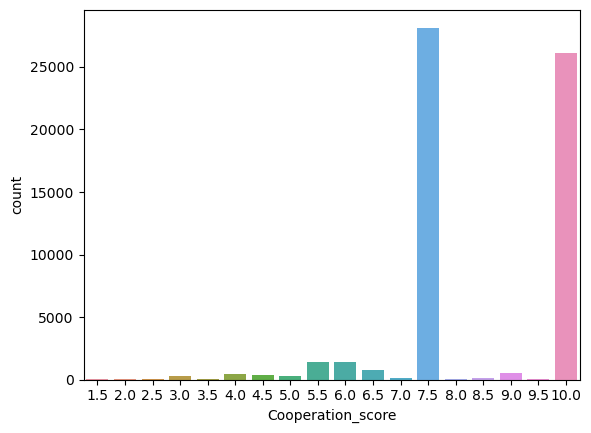

In [6]:
# Distribution of the Cooperation Scores:
sns.countplot(x=df["Cooperation_score"])

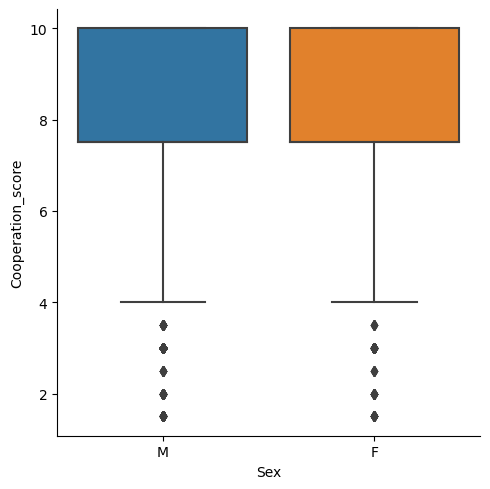

In [7]:
# Box plot for 'Sex':

sns.catplot(data=df, kind="box", x="Sex", y="Cooperation_score")

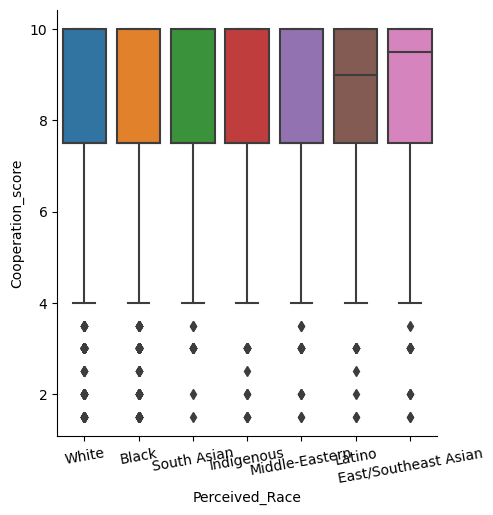

In [64]:
# Box plot for 'Perceived_Race':

cat_plot = sns.catplot(data=df, kind="box", x="Perceived_Race", y="Cooperation_score")
cat_plot.set_xticklabels(rotation=10)
plt.show()

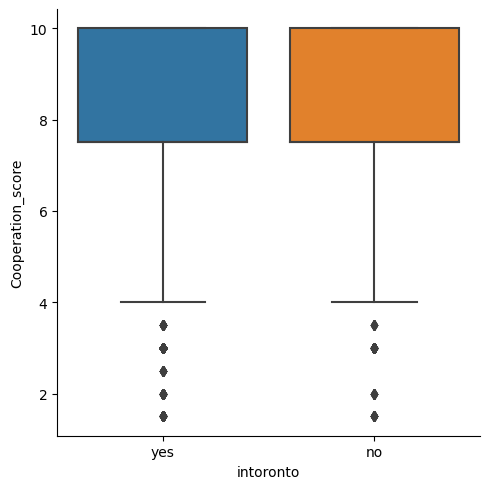

In [9]:
# Box plot for 'intoronto':

sns.catplot(data=df, kind="box", x="intoronto", y="Cooperation_score")

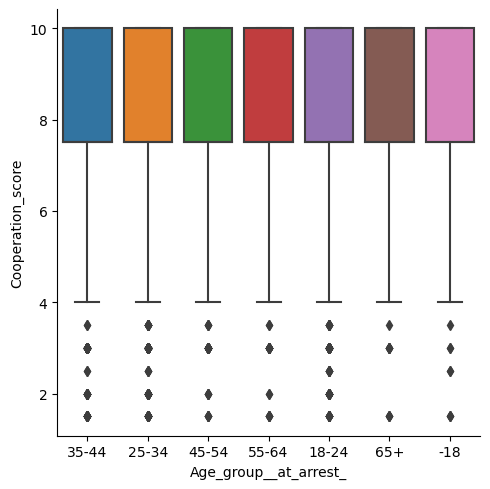

In [10]:
# Box plot for 'Age_group__at_arrest_':

sns.catplot(data=df, kind="box", x="Age_group__at_arrest_", y="Cooperation_score")

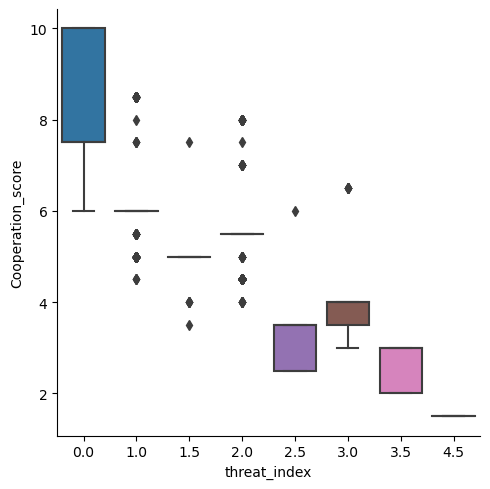

In [11]:
# Box plot for 'threat_index':

sns.catplot(data=df, kind="box", x="threat_index", y="Cooperation_score")

#### 2. power analysis & power graph & t-tests 

In [12]:
from statsmodels.stats.power import TTestIndPower

def pooled_standard_deviation(sample1,sample2):
    #calculate the sample size
    n1, n2 = len(sample1), len(sample2)
    #calculate the variances
    var1, var2 = np.var(sample1, ddof=1), np.var(sample2, ddof=1)
    #calculate the pooled standard deviation
    numerator = ((n1-1) * var1) + ((n2-1) * var2)
    denominator = n1+n2-2
    return np.sqrt(numerator/denominator)
# function to calculate Cohen's d for independent samples
def Cohens_d(sample1, sample2):
    u1, u2 = np.mean(sample1), np.mean(sample2)
    s_pooled = pooled_standard_deviation(sample1, sample2)
    #print(s_pooled)
    return ((u1 - u2) / s_pooled)
def welch_dof(x, y): 
    '''
    Takes in final grades for binary features
    Returns degrees of freedom 
    '''
    dof = (x.var()/x.size + y.var()/y.size)**2 / (
        (x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
    return dof
# power graph function
def generate_power_graph(effect_size, nobs1_actual, nobs2_actual, length):
    # Create an effect size array centered around the given effect size
    effect_sizes = np.array([effect_size - 0.1, effect_size, effect_size + 0.1])
    # Define a range of sample sizes
    sample_sizes = np.array(range(100, length, 100))
    # Initialize power analysis object
    analysis = TTestIndPower()
    # Plot power curves
    analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes, alpha=0.05)
    plt.axvline(x=nobs1_actual, color='g', linestyle='--', lw=2)  
    plt.axvline(x=nobs2_actual, color='b', linestyle='--', lw=2)  
    plt.xlabel('Sample Size')
    plt.ylabel('Power')
    plt.title('Power Graph')
    plt.show()

##### 1) Sex vs Cooperation Score

In [13]:
# power analysis
M_score = df[df["Sex"] == "M"]['Cooperation_score']
F_score = df[df["Sex"] == "F"]['Cooperation_score']
effect_size = Cohens_d(M_score,F_score)
alpha = 0.05
power = 0.8
ratio_ =len(M_score)/len(F_score)
print('Effect size (Cohen\'s D) for Sex vs Cooperation Scores:',effect_size)

analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for M_score') 
print('Actual size of M_score:', len(M_score))
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for F_score')
print('Actual size of F_score:', len(F_score))

Effect size (Cohen's D) for Sex vs Cooperation Scores: 0.031566747547635894
Sample Size of nobs1: 9774.166 needed for M_score
Actual size of M_score: 48505
Sample Size of nobs2: 40583.453 needed for F_score
Actual size of F_score: 11682


/opt/conda/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


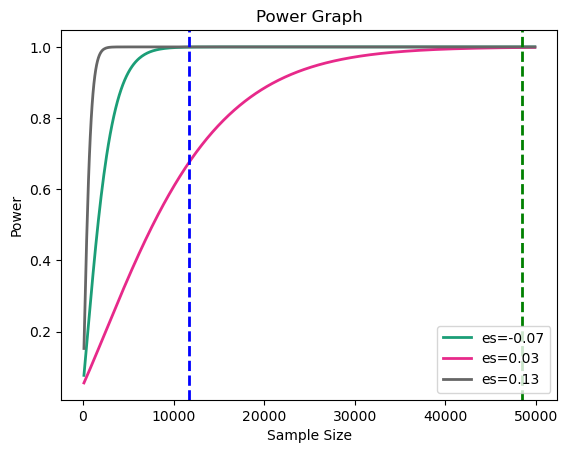

In [14]:
# power graph
# Parameters
effect_size = 0.031566747547635894
nobs1_actual = 48505
nobs2_actual = 11682

generate_power_graph(effect_size, nobs1_actual, nobs2_actual, 50000)

In [15]:
# t-test
print('Ttest results for Cooperation score:',stats.ttest_ind
      (M_score, F_score, equal_var=False))
# calculate mean and standard deviation of groups 
print('Mean score for M_score, F_score:',M_score.mean(), F_score.mean())
print('Standard deviation for M_score, F_score:',M_score.std(), F_score.std())

# compute confidence interval 
cm = sms.CompareMeans(sms.DescrStatsW(M_score), sms.DescrStatsW(F_score))
print('Confidence interval for Cooperation_score:',cm.tconfint_diff(usevar='unequal'))

# welch dof 
print('DOF for Cooperation_score:',welch_dof(M_score, F_score))

Ttest results for Cooperation score: Ttest_indResult(statistic=3.0514465837347644, pvalue=0.002280796050205463)
Mean score for M_score, F_score: 8.423945984950006 8.374807395993837
Standard deviation for M_score, F_score: 1.5548014565343422 1.56433682902184
Confidence interval for Cooperation_score: (0.017574390353293688, 0.08070278755904312)
DOF for Cooperation_score: 17659.601610449165


##### 2) Intoronto vs Cooperation Score

In [16]:
# power analysis
int_score = df[df["intoronto"] == "yes"]['Cooperation_score']
not_score = df[df["intoronto"] == "no"]['Cooperation_score']
effect_size = Cohens_d(int_score,not_score)
alpha = 0.05
power = 0.8
ratio_ =len(int_score)/len(not_score)
print('Effect size (Cohen\'s D) for Intoronto vs Cooperation Scores:',effect_size)

analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for int_score') 
print('Actual size of int_score:', len(int_score))
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for not_score')
print('Actual size of not_score:', len(not_score))

Effect size (Cohen's D) for Intoronto vs Cooperation Scores: -0.03044149561564557
Sample Size of nobs1: 15593.145 needed for int_score
Actual size of int_score: 32694
Sample Size of nobs2: 18542.985 needed for not_score
Actual size of not_score: 27493


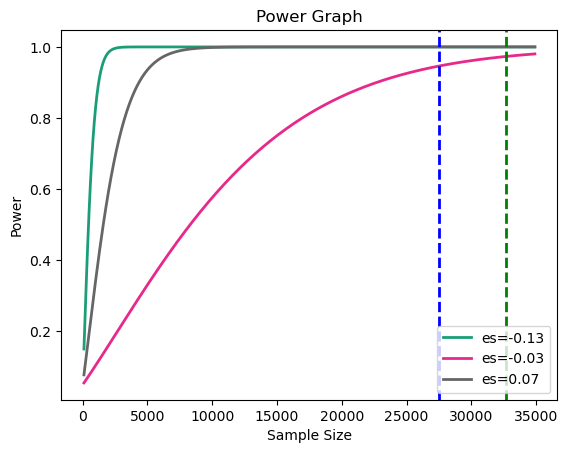

In [17]:
# power graph
# Parameters
effect_size = -0.03044149561564557
nobs1_actual = 32694
nobs2_actual = 27493

generate_power_graph(effect_size, nobs1_actual, nobs2_actual, 35000)

In [18]:
# t-test
print('Ttest results for Cooperation score:',stats.ttest_ind
      (int_score, not_score, equal_var=False)) #p-value is significant

# calculate mean and standard deviation of groups 
print('Mean score for int_score, not_score:',int_score.mean(), not_score.mean())
print('Standard deviation for int_score, not_score:',int_score.std(), not_score.std())

# compute confidence interval 
cm = sms.CompareMeans(sms.DescrStatsW(int_score), sms.DescrStatsW(not_score))
print('Confidence interval for Cooperation_score:',cm.tconfint_diff(usevar='unequal'))

# welch dof 
print('DOF for Cooperation_score:',welch_dof(int_score, not_score))

Ttest results for Cooperation score: Ttest_indResult(statistic=-3.7616145069358, pvalue=0.00016898027266410855)
Mean score for int_score, not_score: 8.392763198140331 8.440148401411268
Standard deviation for int_score, not_score: 1.6443393283543102 1.4453433229524881
Confidence interval for Cooperation_score: (-0.0720754428167012, -0.022694963725171442)
DOF for Cooperation_score: 60067.40549784299


##### 3) Perceived_Race vs Cooperation Score

In [19]:
# power analysis
White_score = df[df["Perceived_Race"] == "White"]['Cooperation_score']
notW_score = df[df["Perceived_Race"] != "White"]['Cooperation_score']
effect_size = Cohens_d(White_score,notW_score)
alpha = 0.05
power = 0.8
ratio_ =len(White_score)/len(notW_score)
print('Effect size (Cohen\'s D) for Perceived_Race vs Cooperation Scores:',effect_size)

analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for White_score') 
print('Actual size of White_score:', len(White_score))
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for notW_score')
print('Actual size of notW_score:', len(notW_score))

Effect size (Cohen's D) for Perceived_Race vs Cooperation Scores: -0.00919055593162749
Sample Size of nobs1: 201847.230 needed for White_score
Actual size of White_score: 27708
Sample Size of nobs2: 172196.898 needed for notW_score
Actual size of notW_score: 32479


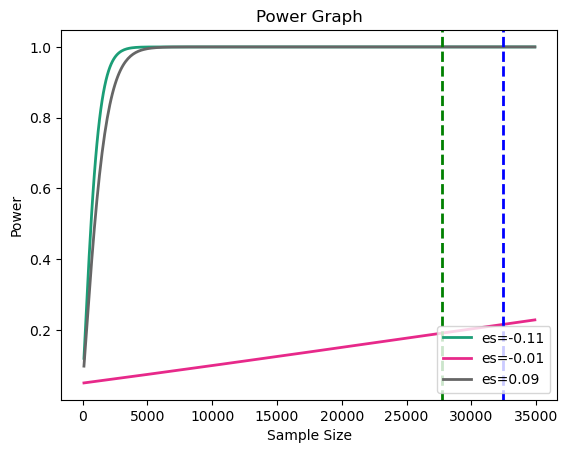

In [20]:
# power graph
# Parameters
effect_size = -0.00919055593162749
nobs1_actual = 27708
nobs2_actual = 32479

generate_power_graph(effect_size, nobs1_actual, nobs2_actual, 35000)

In [21]:
# t-test
print('Ttest results for Cooperation score:',stats.ttest_ind
      (White_score, notW_score, equal_var=False)) #p-value is NOT significant

# calculate mean and standard deviation of groups 
print('Mean score for White_score, notW_score:',White_score.mean(), notW_score.mean())
print('Standard deviation for White_score, notW_score:',
      White_score.std(), notW_score.std())

# compute confidence interval 
cm = sms.CompareMeans(sms.DescrStatsW(White_score), sms.DescrStatsW(notW_score))
print('Confidence interval for Cooperation_score:',cm.tconfint_diff(usevar='unequal'))

# welch dof 
print('DOF for Cooperation_score:',welch_dof(White_score, notW_score))

Ttest results for Cooperation score: Ttest_indResult(statistic=-1.1238286609701196, pvalue=0.26109031573124564)
Mean score for White_score, notW_score: 8.406687599249315 8.42099510452908
Standard deviation for White_score, notW_score: 1.5566212287614145 1.5568814864970149
Confidence interval for Cooperation_score: (-0.039260395543833426, 0.010645384984303004)
DOF for Cooperation_score: 58703.24274146806


##### 4) Age_group__at_arrest vs Cooperation Score

In [22]:
# power analysis
younger_score = df[(df["Age_group__at_arrest_"] == "25-34") | 
                   (df["Age_group__at_arrest_"] == "-18")]['Cooperation_score']
older_score = df[(df["Age_group__at_arrest_"] != "25-34") & 
                 (df["Age_group__at_arrest_"] != "-18")]['Cooperation_score']
effect_size = Cohens_d(younger_score,older_score)
alpha = 0.05
power = 0.8
ratio_ =len(younger_score)/len(older_score)
print('Effect size (Cohen\'s D) for Age_group__at_arrest vs Cooperation Scores:',effect_size)

analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for younger_score') 
print('Actual size of younger_score:', len(younger_score))
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for older_score')
print('Actual size of older_score:', len(older_score))

Effect size (Cohen's D) for Age_group__at_arrest vs Cooperation Scores: -0.029655156298883996
Sample Size of nobs1: 24281.021 needed for younger_score
Actual size of younger_score: 22124
Sample Size of nobs2: 14113.268 needed for older_score
Actual size of older_score: 38063


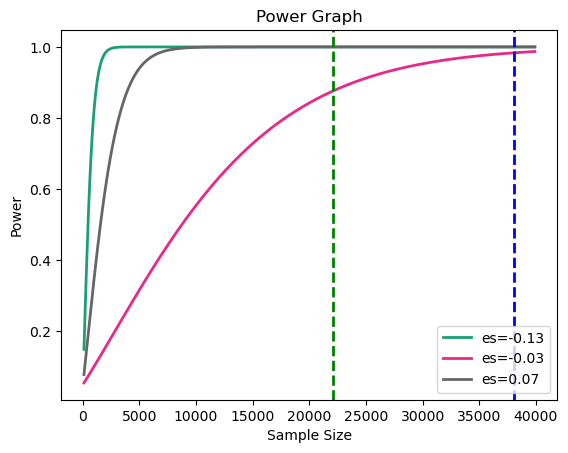

In [23]:
# power graph
# Parameters
effect_size = -0.029655156298883996
nobs1_actual = 22124
nobs2_actual = 38063

generate_power_graph(effect_size, nobs1_actual, nobs2_actual, 40000)

In [24]:
# t-test
print('Ttest results for Cooperation score:',stats.ttest_ind
      (younger_score, older_score, equal_var=False)) #p-value is significant

# calculate mean and standard deviation of groups 
print('Mean score for younger_score, older_score:',younger_score.mean(), 
      older_score.mean())
print('Standard deviation for younger_score, older_score:',younger_score.std(), 
      older_score.std())

# compute confidence interval 
cm = sms.CompareMeans(sms.DescrStatsW(younger_score), sms.DescrStatsW(older_score))
print('Confidence interval for Cooperation_score:',cm.tconfint_diff(usevar='unequal'))

# welch dof 
print('DOF for Cooperation_score:',welch_dof(younger_score, older_score))

Ttest results for Cooperation score: Ttest_indResult(statistic=-3.499847584772494, pvalue=0.0004659652780292937)
Mean score for younger_score, older_score: 8.385215150967275 8.431376927725088
Standard deviation for younger_score, older_score: 1.5650295932096605 1.5517093530108574
Confidence interval for Cooperation_score: (-0.07201370396701576, -0.020309849548610835)
DOF for Cooperation_score: 45914.730438276


##### 5) threat_index (control varaible) vs Cooperation Score

In [25]:
# The power analysis in not performed because the result does not converges.

low_threat = df[df["threat_index"] <= 2]['threat_index']
high_threat = df[df["threat_index"] > 2]['threat_index']

print('Ttest results for Cooperation score:',stats.ttest_ind
      (low_threat, high_threat, equal_var=False)) #p-value is significant

# calculate mean and standard deviation of groups 
print('Mean score for low_threat, high_threat:',low_threat.mean(), high_threat.mean())
print('Standard deviation for low_threat, high_threat:',low_threat.std(), high_threat.std())

# compute confidence interval 
cm = sms.CompareMeans(sms.DescrStatsW(low_threat), sms.DescrStatsW(high_threat))
print('Confidence interval for Cooperation_score:',cm.tconfint_diff(usevar='unequal'))

# welch dof 
print('DOF for Cooperation_score:',welch_dof(low_threat, high_threat))

Ttest results for Cooperation score: Ttest_indResult(statistic=-203.1536086580201, pvalue=0.0)
Mean score for low_threat, high_threat: 0.09198117186577362 3.2204595185995624
Standard deviation for low_threat, high_threat: 0.3831974772483592 0.46312832989100566
Confidence interval for Cooperation_score: (-3.1587001821449356, -3.0982565113226417)
DOF for Cooperation_score: 932.3768475945076


### EDA for independent variables vs Mental instability at arrest

#### 1. Descriptive statistics

<AxesSubplot: xlabel='Mental_instab', ylabel='count'>

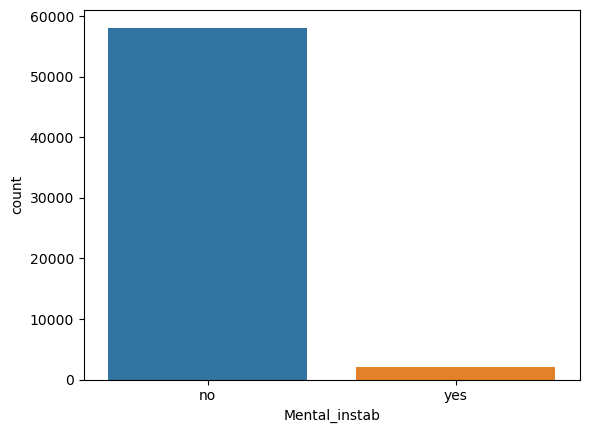

In [26]:
# Distribution of Mental_instab:
sns.countplot(x=df["Mental_instab"])

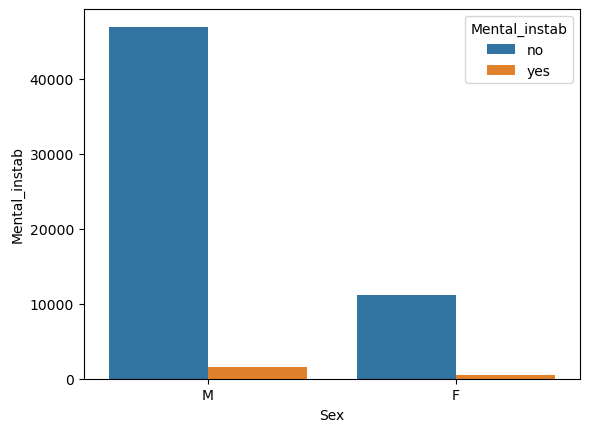

In [27]:
# Count plot for "Sex"
sns.countplot(x='Sex', hue='Mental_instab', data=df)

plt.xlabel('Sex')
plt.ylabel('Mental_instab')

plt.show()

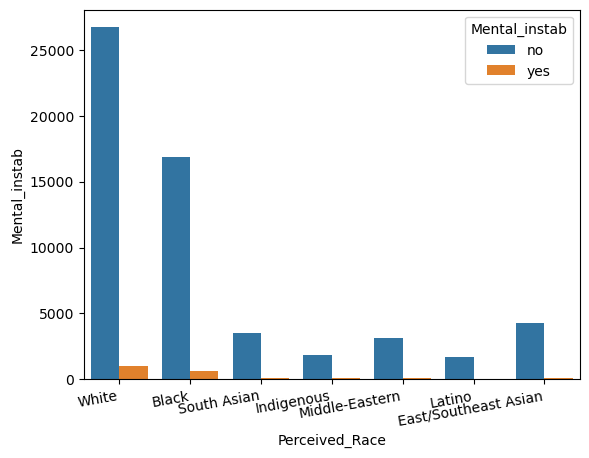

In [65]:
# Count plot for "Perceived_Race"
ax = sns.countplot(x='Perceived_Race', hue='Mental_instab', data=df)

plt.xlabel('Perceived_Race')
plt.ylabel('Mental_instab')
ax.set_xticklabels(ax.get_xticklabels(), rotation=10, horizontalalignment='right')

plt.show()

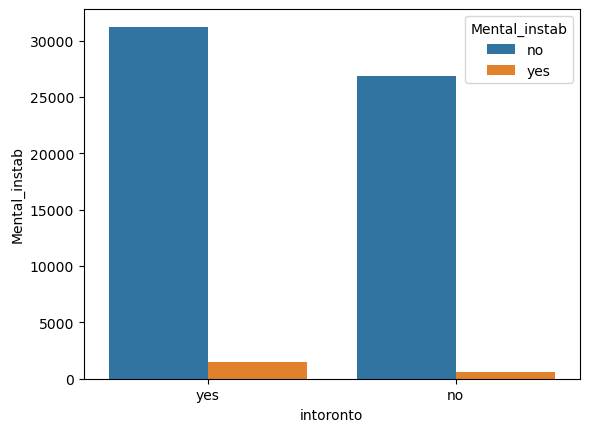

In [29]:
# Count plot for "intoronto"
sns.countplot(x='intoronto', hue='Mental_instab', data=df)

plt.xlabel('intoronto')
plt.ylabel('Mental_instab')

plt.show()

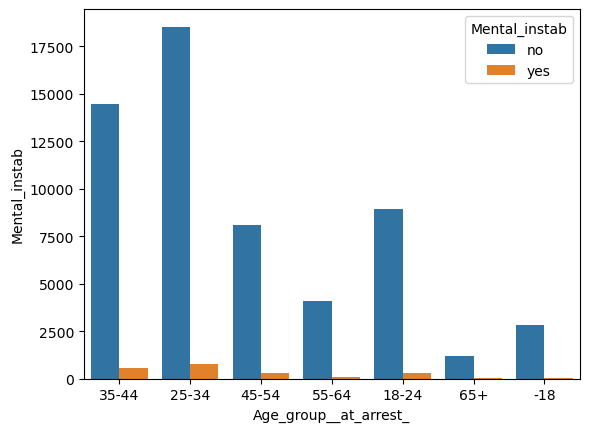

In [30]:
# Count plot for "Age_group__at_arrest_"
sns.countplot(x='Age_group__at_arrest_', hue='Mental_instab', data=df)

plt.xlabel('Age_group__at_arrest_')
plt.ylabel('Mental_instab')

plt.show()

#### 2. power analysis & power graph & t-tests 

##### 1) Sex vs Mental instability at arrest

In [31]:
df_c = df.copy()
df_c['Mental_instab'] = pd.get_dummies(df_c.Mental_instab, drop_first=True)

In [32]:
# power analysis
M_score = df_c[df_c["Sex"] == "M"]['Mental_instab']
F_score = df_c[df_c["Sex"] == "F"]['Mental_instab']
effect_size = Cohens_d(M_score,F_score)
alpha = 0.05
power = 0.8
ratio_ =len(M_score)/len(F_score)
print('Effect size (Cohen\'s D) for Sex vs Mental_instab:',effect_size)

analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for M_score') 
print('Actual size of M_score:', len(M_score))
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for F_score')
print('Actual size of F_score:', len(F_score))

Effect size (Cohen's D) for Sex vs Mental_instab: -0.045105152041185974
Sample Size of nobs1: 4787.451 needed for M_score
Actual size of M_score: 48505
Sample Size of nobs2: 19878.043 needed for F_score
Actual size of F_score: 11682


/opt/conda/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/conda/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


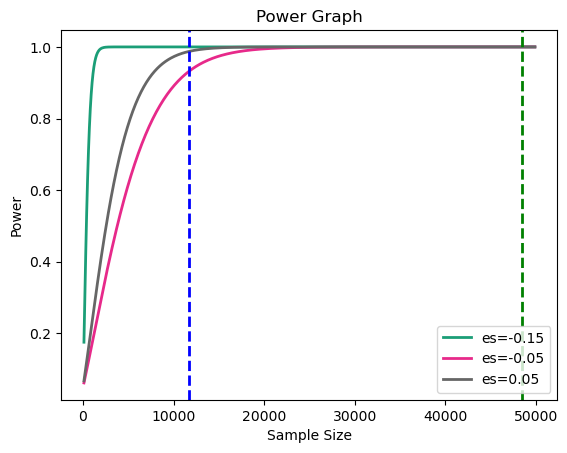

In [33]:
# power graph
# Parameters
effect_size = -0.045105152041185974
nobs1_actual = 48505
nobs2_actual = 11682

generate_power_graph(effect_size, nobs1_actual, nobs2_actual, 50000)

In [34]:
# t-test
print('Ttest results for Mental_instab:',stats.ttest_ind
      (M_score, F_score, equal_var=False))
# calculate mean and standard deviation of groups 
print('Mean score for M_score, F_score:',M_score.mean(), F_score.mean())
print('Standard deviation for M_score, F_score:',M_score.std(), F_score.std())

# compute confidence interval 
cm = sms.CompareMeans(sms.DescrStatsW(M_score), sms.DescrStatsW(F_score))
print('Confidence interval for Mental_instab:',cm.tconfint_diff(usevar='unequal'))

# welch dof 
print('DOF for Mental_instab:',welch_dof(M_score, F_score))

Ttest results for Mental_instab: Ttest_indResult(statistic=-4.09865556848914, pvalue=4.175432703402356e-05)
Mean score for M_score, F_score: 0.03286259148541387 0.04108885464817668
Standard deviation for M_score, F_score: 0.1782787054710461 0.1985042410598912
Confidence interval for Mental_instab: (-0.01216032430512479, -0.004292202020400824)
DOF for Mental_instab: 16510.141582367938


##### 2) Intoronto vs Mental instability at arrest

In [35]:
# power analysis
int_score = df_c[df_c["intoronto"] == "yes"]['Mental_instab']
not_score = df_c[df_c["intoronto"] == "no"]['Mental_instab']
effect_size = Cohens_d(int_score,not_score)
alpha = 0.05
power = 0.8
ratio_ =len(int_score)/len(not_score)
print('Effect size (Cohen\'s D) for Intoronto vs Mental_instab:',effect_size)

analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for int_score') 
print('Actual size of int_score:', len(int_score))
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for not_score')
print('Actual size of not_score:', len(not_score))

Effect size (Cohen's D) for Intoronto vs Mental_instab: 0.12224098976857932
Sample Size of nobs1: 967.836 needed for int_score
Actual size of int_score: 32694
Sample Size of nobs2: 1150.927 needed for not_score
Actual size of not_score: 27493


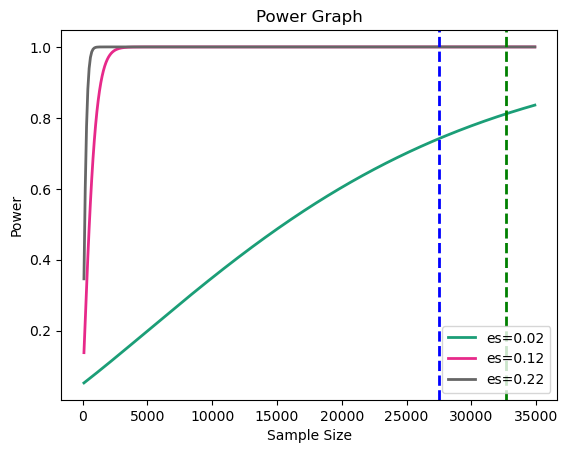

In [36]:
# power graph
# Parameters
effect_size = 0.12224098976857932
nobs1_actual = 32694
nobs2_actual = 27493

generate_power_graph(effect_size, nobs1_actual, nobs2_actual, 35000)

In [37]:
# t-test
print('Ttest results for Mental_instab:',stats.ttest_ind
      (int_score, not_score, equal_var=False)) #p-value is significant

# calculate mean and standard deviation of groups 
print('Mean score for int_score, not_score:',int_score.mean(), not_score.mean())
print('Standard deviation for int_score, not_score:',int_score.std(), not_score.std())

# compute confidence interval 
cm = sms.CompareMeans(sms.DescrStatsW(int_score), sms.DescrStatsW(not_score))
print('Confidence interval for Mental_instab:',cm.tconfint_diff(usevar='unequal'))

# welch dof 
print('DOF for Mental_instab:',welch_dof(int_score, not_score))

Ttest results for Mental_instab: Ttest_indResult(statistic=15.360152665723291, pvalue=3.8433791927234e-53)
Mean score for int_score, not_score: 0.044625925246222546 0.022369330375004548
Standard deviation for int_score, not_score: 0.20648427573831352 0.1478842077413722
Confidence interval for Mental_instab: (0.019416582530776057, 0.02509660721165994)
DOF for Mental_instab: 58747.61354713609


##### 3) Perceived_Race vs Mental instability at arrest

In [38]:
# power analysis
White_score = df_c[df_c["Perceived_Race"] == "White"]['Mental_instab']
notW_score = df_c[df_c["Perceived_Race"] != "White"]['Mental_instab']
effect_size = Cohens_d(White_score,notW_score)
alpha = 0.05
power = 0.8
ratio_ =len(White_score)/len(notW_score)
print('Effect size (Cohen\'s D) for Perceived_Race vs Mental_instab:',effect_size)

analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for White_score') 
print('Actual size of White_score:', len(White_score))
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for notW_score')
print('Actual size of notW_score:', len(notW_score))

Effect size (Cohen's D) for Perceived_Race vs Mental_instab: 0.013273896149384198
Sample Size of nobs1: 96763.585 needed for White_score
Actual size of White_score: 27708
Sample Size of nobs2: 82549.506 needed for notW_score
Actual size of notW_score: 32479


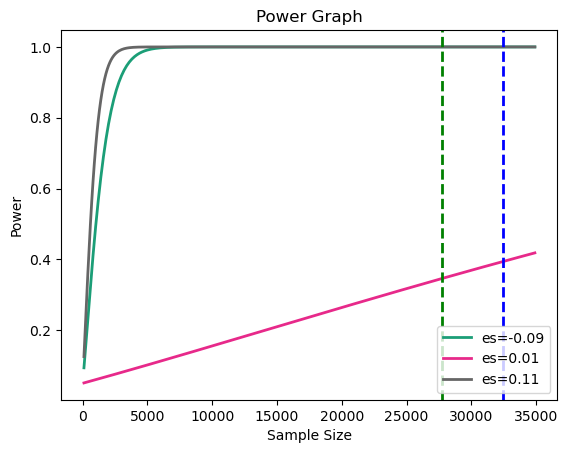

In [39]:
# power graph
# Parameters
effect_size = 0.013273896149384198
nobs1_actual = 27708
nobs2_actual = 32479

generate_power_graph(effect_size, nobs1_actual, nobs2_actual, 35000)

In [40]:
# t-test
print('Ttest results for Mental_instab:',stats.ttest_ind
      (White_score, notW_score, equal_var=False)) #p-value is NOT significant

# calculate mean and standard deviation of groups 
print('Mean score for White_score, notW_score:',White_score.mean(), notW_score.mean())
print('Standard deviation for White_score, notW_score:',
      White_score.std(), notW_score.std())

# compute confidence interval 
cm = sms.CompareMeans(sms.DescrStatsW(White_score), sms.DescrStatsW(notW_score))
print('Confidence interval for Mental_instab:',cm.tconfint_diff(usevar='unequal'))

# welch dof 
print('DOF for Mental_instab:',welch_dof(White_score, notW_score))

Ttest results for Mental_instab: Ttest_indResult(statistic=1.618780223979806, pvalue=0.10549999287788493)
Mean score for White_score, notW_score: 0.03576584379962466 0.03334462267926968
Standard deviation for White_score, notW_score: 0.18570916215344224 0.17953760404620767
Confidence interval for Mental_instab: (-0.0005103721269177413, 0.005352814367627696)
DOF for Mental_instab: 58031.65095022261


##### 4) Age_group__at_arrest vs Mental instability at arrest

In [41]:
# power analysis
younger_score = df_c[(df_c["Age_group__at_arrest_"] == "25-34") | 
                   (df_c["Age_group__at_arrest_"] == "-18")]['Mental_instab']
older_score = df_c[(df_c["Age_group__at_arrest_"] != "25-34") & 
                 (df_c["Age_group__at_arrest_"] != "-18")]['Mental_instab']
effect_size = Cohens_d(younger_score,older_score)
alpha = 0.05
power = 0.8
ratio_ =len(younger_score)/len(older_score)
print('Effect size (Cohen\'s D) for Age_group__at_arrest vs Mental_instab:',effect_size)

analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size, power=power, nobs1=None, ratio=ratio_, alpha=alpha)
print('Sample Size of nobs1: %.3f' % sample_size, 'needed for younger_score') 
print('Actual size of younger_score:', len(younger_score))
nobs2 =ratio_*sample_size
print('Sample Size of nobs2: %.3f' % nobs2, 'needed for older_score')
print('Actual size of older_score:', len(older_score))

Effect size (Cohen's D) for Age_group__at_arrest vs Mental_instab: 0.010823543475433762
Sample Size of nobs1: 182267.661 needed for younger_score
Actual size of younger_score: 22124
Sample Size of nobs2: 105942.509 needed for older_score
Actual size of older_score: 38063


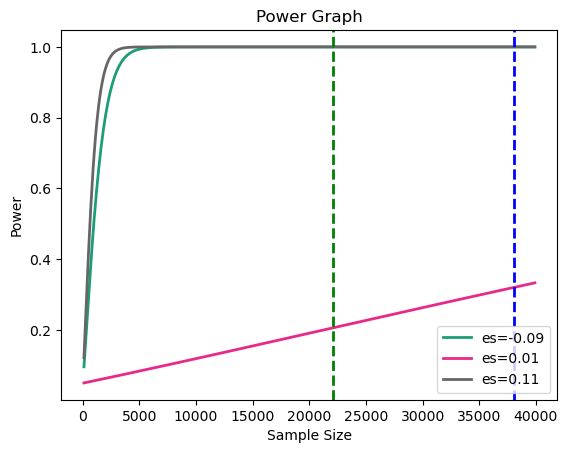

In [42]:
# power graph
# Parameters
effect_size = 0.010823543475433762
nobs1_actual = 22124
nobs2_actual = 38063

generate_power_graph(effect_size, nobs1_actual, nobs2_actual, 40000)

In [43]:
# t-test
print('Ttest results for Mental_instab:',stats.ttest_ind
      (younger_score, older_score, equal_var=False)) #p-value is significant

# calculate mean and standard deviation of groups 
print('Mean score for younger_score, older_score:',younger_score.mean(), 
      older_score.mean())
print('Standard deviation for younger_score, older_score:',younger_score.std(), 
      older_score.std())

# compute confidence interval 
cm = sms.CompareMeans(sms.DescrStatsW(younger_score), sms.DescrStatsW(older_score))
print('Confidence interval for Mental_instab:',cm.tconfint_diff(usevar='unequal'))

# welch dof 
print('DOF for Mental_instab:',welch_dof(younger_score, older_score))

Ttest results for Mental_instab: Ttest_indResult(statistic=1.2710068369674674, pvalue=0.20373275582980135)
Mean score for younger_score, older_score: 0.035707828602422706 0.03373354701416073
Standard deviation for younger_score, older_score: 0.18556491048535878 0.1805448730968594
Confidence interval for Mental_instab: (-0.0010702531009277264, 0.005018816277451677)
DOF for Mental_instab: 45210.32641010318


### ANCOVA on Cooperation Score

In [44]:
from pingouin import ancova
pd.options.display.max_columns = None #show all columns in data

In [45]:
df_1way = df[['Sex', 'Perceived_Race', 'Age_group__at_arrest_', 'intoronto', 'Cooperation_score', 'threat_index']].copy()

In [46]:
# independent categorical variables (Since there are four independent variables, we will run one ANCOVA for each of them)
for var in ['Sex', 'Perceived_Race', 'Age_group__at_arrest_', 'intoronto']:
    print(var, ': ', df_1way[var].unique())

Sex :  ['M' 'F']
Perceived_Race :  ['White' 'Black' 'South Asian' 'Indigenous' 'Middle-Eastern' 'Latino'
 'East/Southeast Asian']
Age_group__at_arrest_ :  ['35-44' '25-34' '45-54' '55-64' '18-24' '65+' '-18']
intoronto :  ['yes' 'no']


In [47]:
# continuous control variable
df_1way['threat_index'].unique()

array([0. , 1. , 2. , 3.5, 3. , 1.5, 4.5, 2.5])

In [48]:
# continous dependent variable
df_1way['Cooperation_score'].unique()

array([10. ,  7.5,  5. ,  6. ,  6.5,  5.5,  3. ,  4.5,  4. ,  9. ,  3.5,
        1.5,  2. ,  7. ,  8. ,  8.5,  9.5,  2.5])

In [49]:
df_1way.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60187 entries, 0 to 65275
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Sex                    60187 non-null  object 
 1   Perceived_Race         60187 non-null  object 
 2   Age_group__at_arrest_  60187 non-null  object 
 3   intoronto              60187 non-null  object 
 4   Cooperation_score      60187 non-null  float64
 5   threat_index           60187 non-null  float64
dtypes: float64(2), object(4)
memory usage: 3.2+ MB


In [50]:
# Perform one ANCOVA based on each independent variable + control vs dependent variable
for var in ['Sex', 'Perceived_Race', 'Age_group__at_arrest_', 'intoronto']:
    print(ancova(data=df_1way, dv='Cooperation_score', covar='threat_index', between=var))
    print("-------------------------------------------------------------------------------")

         Source            SS     DF             F     p-unc       np2
0           Sex     23.863475      1     15.597172  0.000078  0.000259
1  threat_index  53758.339558      1  35136.462318  0.000000  0.368614
2      Residual  92080.752997  60184           NaN       NaN       NaN
-------------------------------------------------------------------------------
           Source            SS     DF             F         p-unc       np2
0  Perceived_Race    205.818396      6     22.463016  1.358838e-26  0.002235
1    threat_index  53356.952429      1  34940.261543  0.000000e+00  0.367331
2        Residual  91898.798076  60179           NaN           NaN       NaN
-------------------------------------------------------------------------------
                  Source            SS     DF             F    p-unc       np2
0  Age_group__at_arrest_     42.283587      6      4.606632  0.00011  0.000459
1           threat_index  53612.061995      1  35044.954626  0.00000  0.368027
2          

### Logistic Regression on Mental instability at arrest

In [51]:
x = df[['Sex', 'Perceived_Race', 'Age_group__at_arrest_', 'intoronto']].copy()
x['intoronto'] = pd.get_dummies(df.intoronto, drop_first=True)

y = pd.get_dummies(df.Mental_instab, drop_first=True)

In [52]:
x.groupby('intoronto').size()

intoronto
0    27493
1    32694
dtype: int64

In [53]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60187 entries, 0 to 65275
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Sex                    60187 non-null  object
 1   Perceived_Race         60187 non-null  object
 2   Age_group__at_arrest_  60187 non-null  object
 3   intoronto              60187 non-null  uint8 
dtypes: object(3), uint8(1)
memory usage: 1.9+ MB


In [54]:
y['yes'].unique()

array([0, 1], dtype=uint8)

In [55]:
# Create the formula string 
all_columns = ' + '.join(x)
formula = "yes ~ " + all_columns 
print("Formula: ", formula, "\n")

data = pd.concat([x,y], axis = 1)

# Build the model
log_reg = smf.logit(formula, data=data).fit()

Formula:  yes ~ Sex + Perceived_Race + Age_group__at_arrest_ + intoronto 

Optimization terminated successfully.
         Current function value: 0.146229
         Iterations 9


In [56]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                    yes   No. Observations:                60187
Model:                          Logit   Df Residuals:                    60172
Method:                           MLE   Df Model:                           14
Date:                Mon, 03 Apr 2023   Pseudo R-squ.:                 0.02460
Time:                        22:11:49   Log-Likelihood:                -8801.1
converged:                       True   LL-Null:                       -9023.0
Covariance Type:            nonrobust   LLR p-value:                 6.989e-86
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                 -5.2855      0.257    -20.584      0.000      -5.789      -4.782
Sex[T.M]                                  -0.26

In [57]:
# getting odds ratio
np.exp(log_reg.params)

Intercept                                 0.005064
Sex[T.M]                                  0.763954
Perceived_Race[T.East/Southeast Asian]    0.634899
Perceived_Race[T.Indigenous]              0.963986
Perceived_Race[T.Latino]                  0.599068
Perceived_Race[T.Middle-Eastern]          0.924268
Perceived_Race[T.South Asian]             0.593059
Perceived_Race[T.White]                   0.915474
Age_group__at_arrest_[T.18-24]            5.455093
Age_group__at_arrest_[T.25-34]            7.264419
Age_group__at_arrest_[T.35-44]            7.085320
Age_group__at_arrest_[T.45-54]            6.357336
Age_group__at_arrest_[T.55-64]            4.904840
Age_group__at_arrest_[T.65+]              4.627445
intoronto                                 2.020772
dtype: float64

In [58]:
params = log_reg.params
conf = log_reg.conf_int()
conf['OR'] = params
conf.columns = ["Lower CI", "Upper CI", "OR"]
np.exp(conf)

,Lower CI,Upper CI,OR
Intercept,0.003062,0.008377,0.005064
Sex[T.M],0.687417,0.849014,0.763954
Perceived_Race[T.East/Southeast Asian],0.515281,0.782284,0.634899
Perceived_Race[T.Indigenous],0.757264,1.227139,0.963986
Perceived_Race[T.Latino],0.436540,0.822105,0.599068
Perceived_Race[T.Middle-Eastern],0.752010,1.135983,0.924268
Perceived_Race[T.South Asian],0.469775,0.748696,0.593059
Perceived_Race[T.White],0.825875,1.014792,0.915474
Age_group__at_arrest_[T.18-24],3.288263,9.049775,5.455093
Age_group__at_arrest_[T.25-34],4.418219,11.944130,7.264419


In [59]:
# assess the model
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=123)
# Predict responses 
pred = log_reg.predict(x_test)
prediction = list(map(round, pred))

# Accuracy score
print('\nTest accuracy = ', accuracy_score(y_test, prediction))


Test accuracy =  0.9637813590297392


In [60]:
# Confusion matrix
# C0,0 is true negative, C1,0 is false negative,
# C1,1 is true positive, C0,1 false positive 

cm = confusion_matrix(y_test, prediction) 
print ("\nConfusion Matrix : \n", cm) 


Confusion Matrix : 
 [[11602     0]
 [  436     0]]
